Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en `Material_TPs/TP3/images` a partir del template `Material_TPs/TP3/template`

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [182]:
#%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [183]:
def show_gray_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()


def show_bgr_img(img):
    plt.imshow(img[..., ::-1])
    plt.axis("off")
    plt.show()

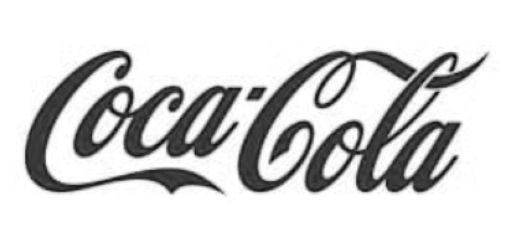

In [184]:
TEMPLATE_PATH = 'material/template/pattern.png'
template = cv.imread(TEMPLATE_PATH, 0)
show_gray_img(template)
i = cv.imread('material/images/coca_logo_2.png', 0)

In [185]:
def check_sizes(template, img):
    if template.shape[0] > img.shape[0] or template.shape[1] > img.shape[1]:
        raise Exception('Invalid template size')

def do_template_matching(template, img_gray, method):
    check_sizes(template, img_gray)
    res = cv.matchTemplate(img_gray, template, eval(method))
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

    if method in ['cv.TM_SQDIFF_NORMED', 'cv.TM_SQDIFF']:
        top_left = min_loc
        max_val_ncc = '{:.3f}'.format(min_val)
    else:
        top_left = max_loc
        max_val_ncc = '{:.3f}'.format(max_val)

    return max_val_ncc, top_left

def scale_img(scales, img):
    resized_imgs = list()
    for scale in scales:
        resized_imgs.append(cv.resize(img, None, fx=scale, fy=scale))
    return resized_imgs

def get_bottom_right(top_left, template):
    w, h = template.shape[::-1]
    return int(top_left[0] + w), int(top_left[1] + h)

def draw_text(img, top_left, acc, color=(255, 0, 0)):
    label = f'Confianza: {int(float(acc) * 100)}%'
    (label_width, label_height), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 1, 2)

    text_start = (top_left[0], top_left[1] - label_height)
    text_end = (top_left[0] + label_width, top_left[1])

    font_scale = 1
    if text_end[0] > img.shape[1]:
        font_scale = 0.5

    cv.rectangle(img, text_start, text_end, (0,0,0),-1)
    cv.putText(img, label, top_left, cv.FONT_HERSHEY_SIMPLEX, font_scale, color, 2, cv.LINE_AA)

    return img

def draw_rectangle(img, top_left, bottom_right, acc, color=(255, 0, 0), thickness=3):
    cv.rectangle(img, top_left, bottom_right, color, thickness)
    draw_text(img, top_left, acc, color)
    return img

def draw_match(img, best_match):
    top_left = best_match[1]
    t_scale = best_match[2]
    bottom_right = get_bottom_right(top_left, template, t_scale)
    output_image = draw_rectangle(img, top_left, bottom_right)
    print('used', best_match[0], top_left, bottom_right, t_scale, best_match[3])
    return output_image

In [186]:
def remove_overlapping_matches(matches):
    to_keep = list()
    while len(matches) > 0:
        rect_1, acc = matches.pop(0)
        overlapped = False
        for rect, acc in to_keep:
            if do_overlap(*rect_1, *rect):
                overlapped = True
                break
        if not overlapped:
            to_keep.append((rect_1, acc))
    return to_keep


def do_overlap(tl1, br1, tl2, br2):
    if tl1[0] >= br2[0] or br1[0] <= tl2[0] or br1[1] <= tl2[1] or tl1[1] >= br2[1]:
        return False
    return True


def get_automatic_threshold(res, method):
    min_val, max_val, _, __ = cv.minMaxLoc(res)

    if method in ['cv.TM_SQDIFF_NORMED', 'cv.TM_SQDIFF']:
        max_val_ncc = '{:.3f}'.format(min_val)
    else:
        max_val_ncc = '{:.3f}'.format(max_val)

    return float(max_val_ncc) * 0.95

In [187]:
def preprocess_image(img, scale):
    denoise = cv.fastNlMeansDenoising(img, None, 20, 7, 21)
    canny_img = cv.Canny(denoise, 100, 260, apertureSize=3)
    scaled_img = cv.resize(canny_img, None, fx=scale, fy=scale)
    return scaled_img

METHODS = [
    'cv.TM_CCOEFF_NORMED',
    'cv.TM_CCORR_NORMED',
]

def do_multi_match_template(output_image, image_to_compare, template_used, best_match, threshold=None):
    res = cv.matchTemplate(image_to_compare,template_used, eval(best_match['method']))

    if threshold is None:
        # threshold usado para buscar multiples detecciones
        # si no es pasado manualmente, se utiliza el max_val_ncc * 0.95
        threshold = get_automatic_threshold(res, best_match['method'])

    loc = np.where(res >= threshold)

    matches = list()
    for pt in zip(*loc[::-1]):
        top_left = pt
        bottom_right = get_bottom_right(top_left, template_used)
        matches.append(((top_left, bottom_right), res[pt[::-1]]))

    matches = remove_overlapping_matches(matches)

    for (top_left, bottom_right), acc in matches:
        draw_rectangle(output_image, top_left, bottom_right, acc)

    return output_image

def match_template_alg(image, template, multi_match=False, threshold=None):
    scales = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 1.5, 2]
    templates = list()
    img_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    img_to_compare = preprocess_image(img_gray, 1)

    for scale in scales:
        templates.append(preprocess_image(template, scale))


    best_match = None

    for meth in METHODS:
        for t_scale_index, templ in enumerate(templates):
            try:
                max_val_ncc, top_left = do_template_matching(templ, img_to_compare, meth)
                if best_match is None or max_val_ncc > best_match['acc']:
                    t_scale = scales[t_scale_index]
                    top_left = int(top_left[0]), int(top_left[1])
                    bottom_right = get_bottom_right(top_left, templ)
                    best_match = {
                        'acc': max_val_ncc,
                        'top_left': top_left,
                        'bottom_right': bottom_right,
                        'i_scale': 1,
                        't_scale': t_scale,
                        'method': meth
                    }

            except Exception:
                break
    if best_match is None:
        raise Exception('No match found')

    if multi_match:
        template_index_used = list(scales).index(best_match['t_scale'])
        return do_multi_match_template(image.copy(), img_to_compare, templates[template_index_used], best_match, threshold)
    else:
        output_image = draw_rectangle(image.copy(),
                                  best_match['top_left'],
                                  best_match['bottom_right'],
                                  best_match['acc'])
        return output_image

Ejercicios 1, 2 y 3. Es decir, metodo general que busca de la mejor manera el template, y en caso que haya mas de uno, los muestra todos.

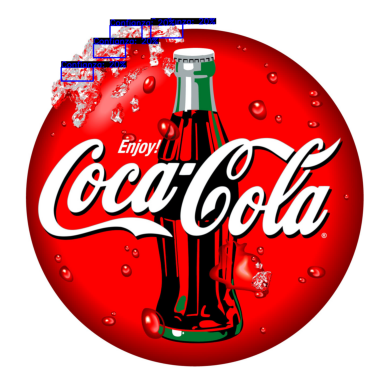

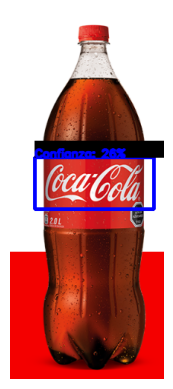

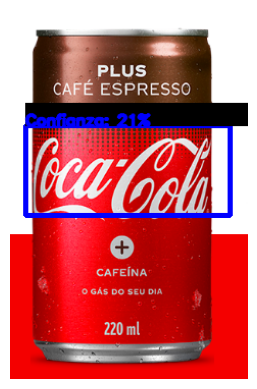

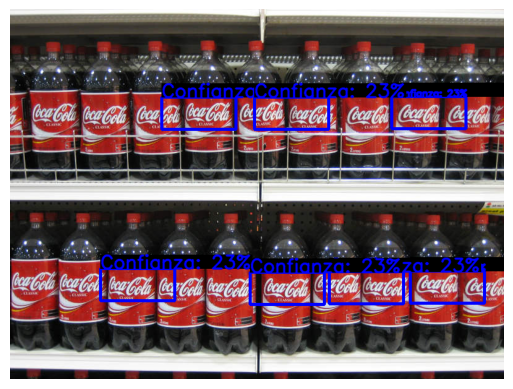

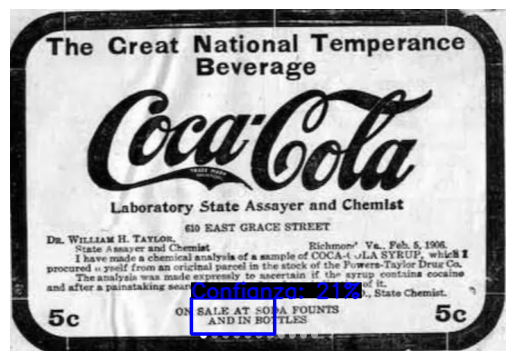

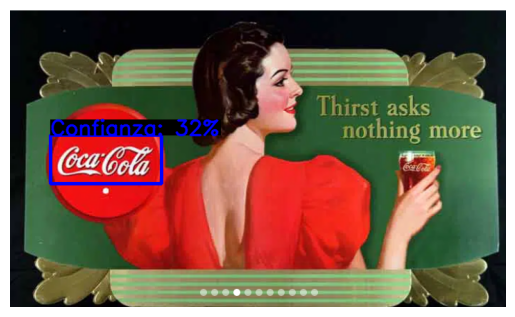

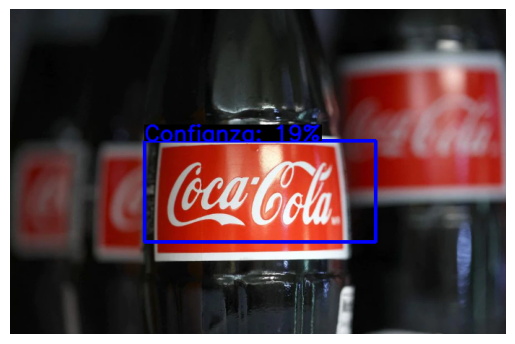

In [188]:
IMAGES_PATH = 'material/images'

for filename in sorted(os.listdir(IMAGES_PATH)):
    f = os.path.join(IMAGES_PATH, filename)
    img = cv.imread(f)
    result = match_template_alg(img, template, True)
    show_bgr_img(result)

Alternativa para el Ejercicio 2, pero sin generalizar, es decir, usando los mejores valores posibles para esa imagen en particular

In [189]:
def remove_overlapping_matches(matches):
    to_keep = list()
    while len(matches) > 0:
        rect_1 = matches.pop(0)
        overlapped = False
        for rect in to_keep:
            if do_overlap(*rect_1, *rect):
                overlapped = True
                break
        if not overlapped:
            to_keep.append(rect_1)
    return to_keep


def do_overlap(tl1, br1, tl2, br2):
    if tl1[0] >= br2[0] or br1[0] <= tl2[0] or br1[1] <= tl2[1] or tl1[1] >= br2[1]:
        return False
    return True


def get_automatic_threshold(res, method):
    min_val, max_val, _, __ = cv.minMaxLoc(res)

    if method in ['cv.TM_SQDIFF_NORMED', 'cv.TM_SQDIFF']:
        max_val_ncc = '{:.3f}'.format(min_val)
    else:
        max_val_ncc = '{:.3f}'.format(max_val)

    return float(max_val_ncc) * 0.9

def preprocess_image(img, scale):
    scaled_img = cv.resize(img, None, fx=scale, fy=scale)
    canny_img = cv.Canny(scaled_img, 220, 260, apertureSize=3)
    return canny_img

In [190]:
def multi_match_template(img, template, method, template_scale, image_scale, threshold):

    processed_template = preprocess_image(template, template_scale)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    processed_image = preprocess_image(img_gray, image_scale)
    res = cv.matchTemplate(processed_image, processed_template, eval(method))

    loc = np.where(res >= threshold)
    output_image = img.copy()

    matches = list()
    for pt in zip(*loc[::-1]):
        top_left = int(pt[0]/image_scale), int(pt[1]/image_scale)
        bottom_right = get_bottom_right(top_left, processed_template)
        matches.append((top_left, bottom_right))

    matches = remove_overlapping_matches(matches)

    for top_left, bottom_right in matches:
        cv.rectangle(output_image, top_left, bottom_right, (255, 0, 0), 2),
    return output_image

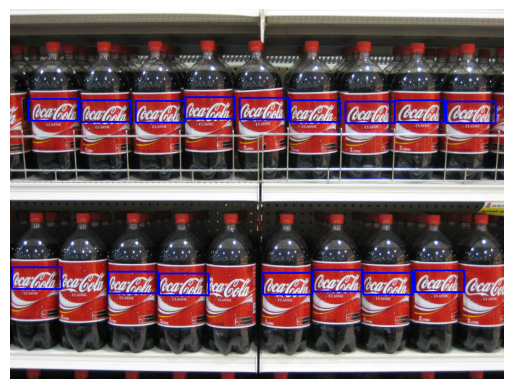

In [191]:
image = cv.imread('material/images/coca_multi.png')
method = "cv.TM_CCORR_NORMED"
template_scale = 0.2
image_scale = 1.0

show_bgr_img(multi_match_template(image, template, method, template_scale, image_scale, 0.31))